In [4]:
# Convolutional Neural Networks
# Setup & Die "Tensoren"
# Zuerst müssen wir verstehen, dass PyTorch Bilder nicht als NumPy-Arrays, sondern als Tensoren sieht.
# Ein Tensor ist eine höherdimensionale Matrixverallgemeinerung, die auf der Grafikkarte (GPU) leben kann.

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Gerät auswählen (GPU wenn verfügbar, sonst CPU)
# Auf Mac M1/M2 Chips wäre das "mps", auf Nvidia "cuda"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Wir trainieren auf: {device}")

# 2. Hyperparameter setzen (Die Stellschrauben)
BATCH_SIZE = 64     # Wie viele Bilder schauen wir uns gleichzeitig an?
LEARNING_RATE = 0.001 # Wie große Schritte machen wir beim Lernen?
EPOCHS = 5          # Wie oft gehen wir durch den ganzen Datensatz?

Wir trainieren auf: cpu


Lade Daten...


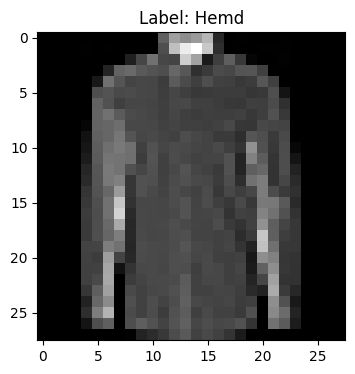

In [5]:
# Daten laden (Fashion-MNIST)
# PyTorch nimmt uns hier viel Arbeit ab. Der DataLoader mischt die Daten und serviert sie häppchenweise.
# Transformation: Bild -> Tensor -> Normalisierung (Werte zwischen -1 und 1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Daten herunterladen
print("Lade Daten...")
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Dataloader erstellen
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Klassen-Namen (damit wir wissen, was 0-9 bedeutet)
classes = ('T-Shirt', 'Hose', 'Pullover', 'Kleid', 'Mantel',
           'Sandale', 'Hemd', 'Sneaker', 'Tasche', 'Stiefel')

# Kleiner Check: Ein Bild anzeigen
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(4,4))
plt.imshow(images[0].squeeze(), cmap='gray') # .squeeze entfernt den Kanal (1, 28, 28) -> (28, 28)
plt.title(f"Label: {classes[labels[0]]}")
plt.show()

In [6]:
# Der Architekt – Das CNN bauen
# Hier übersetzen wir die Theorie-Folien direkt in Code. Wir bauen eine Klasse, die von nn.Module erbt.
# Rechnen Sie die Größen mit!
# Input: 28 x 28
# Conv1 (5 x 5 Kernel, kein Padding, Stride 1): 28 - 5 + 1 = 24 x 24
# Pool (2 x 2): 24 / 2 = 12 x 12
# Conv2 (5 x 5 Kernel): 12 - 5 + 1 = 8 x 8
# Pool (2 x 2): 8 / 2 = 4 x 4
# Flatten: 4 x 4 x 16  Filter = 256 Neuronen.

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Block 1: Conv -> ReLU -> Pool
        # Input Kanäle: 1 (Graustufen), Output Kanäle: 10 (Filter lernen 10 Merkmale)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2: Conv -> ReLU -> Pool
        # Input: 10 (von oben), Output: 20 (wir lernen mehr Details)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)

        # Fully Connected Layer (Klassifikation)
        # 4*4*20 ist die Größe der abgeflachten Feature Maps (siehe Rechnung oben)
        self.fc1 = nn.Linear(20 * 4 * 4, 50) # Hidden Layer
        self.fc2 = nn.Linear(50, 10)         # Output Layer (10 Klassen)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Der Weg der Daten durch das Netz
        x = self.pool(self.relu(self.conv1(x))) # Layer 1
        x = self.pool(self.relu(self.conv2(x))) # Layer 2

        # Flatten: Aus 3D-Würfel wird 1D-Vektor
        x = x.view(-1, 20 * 4 * 4)

        x = self.relu(self.fc1(x))
        x = self.fc2(x) # Kein Softmax hier! Das macht CrossEntropyLoss automatisch.
        return x

# Modell initialisieren und auf das Gerät schieben
net = SimpleCNN().to(device)
print(net)

SimpleCNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)


![](https://encrypted-tbn2.gstatic.com/licensed-image?q=tbn:ANd9GcQonS7jFFbs4xilesxcEq2Xdg5EDM5iuEmJhvpFI6bTw77yo0ZEzSYIiyBiE6vAi2roCFWGde54zL_ikLixq1KyebCgNAWAtAMgSU-GYbeWh5keqgA)

Start Training... (Holen Sie sich einen Kaffee, das dauert kurz)
Epoche 1/5 abgeschlossen - Loss: 0.5960
Epoche 2/5 abgeschlossen - Loss: 0.3864
Epoche 3/5 abgeschlossen - Loss: 0.3423
Epoche 4/5 abgeschlossen - Loss: 0.3141
Epoche 5/5 abgeschlossen - Loss: 0.2948
Training beendet!


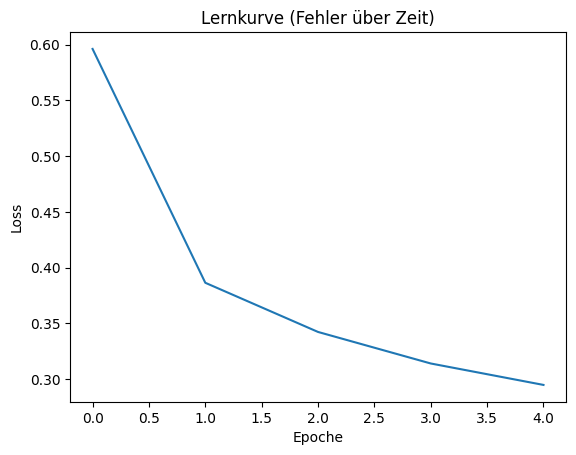

In [7]:
# Die Training Loop (Lernen lassen)

# Das ist der magische Moment. Wir sehen zu, wie der "Loss" (Fehler) sinkt.

# Verlustfunktion (Klassifikations-Fehler)
criterion = nn.CrossEntropyLoss()

# Optimierer (Der Gradienten-Abstieg / "Bergabsteiger")
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

loss_history = []

print("Start Training... (Holen Sie sich einen Kaffee, das dauert kurz)")

for epoch in range(EPOCHS):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # A. Gradienten auf Null setzen (wichtig!)
        optimizer.zero_grad()

        # B. Forward Pass (Vorhersage machen)
        outputs = net(inputs)

        # C. Loss berechnen (Wie falsch lagen wir?)
        loss = criterion(outputs, labels)

        # D. Backward Pass (Lernen / Gewichte anpassen)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Statistik pro Epoche
    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoche {epoch + 1}/{EPOCHS} abgeschlossen - Loss: {avg_loss:.4f}')

print('Training beendet!')

# Loss-Kurve plotten
plt.plot(loss_history)
plt.title("Lernkurve (Fehler über Zeit)")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.show()

In [8]:
# Evaluation (Die Prüfung)

# Wie gut ist das Modell wirklich? Wir testen es an Daten, die es noch nie gesehen hat.

correct = 0
total = 0

# torch.no_grad() spart Speicher, da wir hier nicht lernen müssen
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = net(images)

        # torch.max gibt uns den Index mit der höchsten Wahrscheinlichkeit
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Genauigkeit auf 10.000 Testbildern: {100 * correct / total:.2f}%')

Genauigkeit auf 10.000 Testbildern: 88.54%


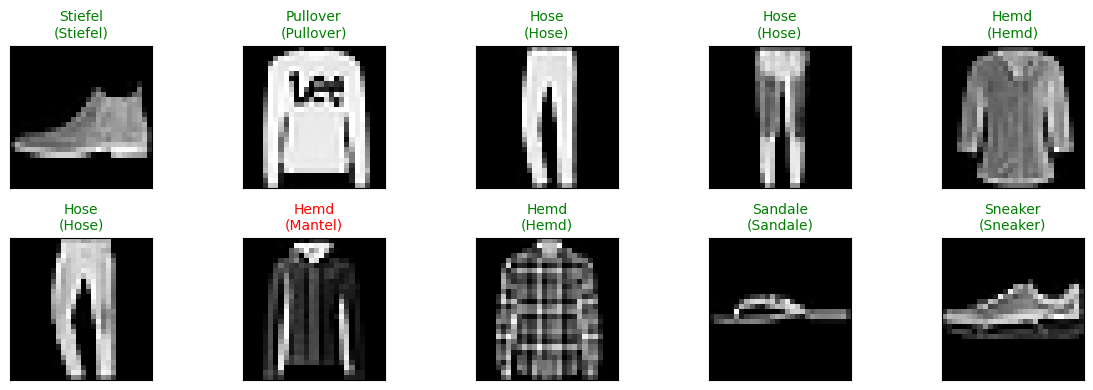

In [9]:
# Visuelle Demo (Anwendung)
# Die Zahlen sind gut, Bilder sind besser. Wir zeigen Vorhersagen an.

# Wir holen uns einen Batch Testbilder
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Vorhersage
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

# Plotten der ersten 10 Bilder
fig = plt.figure(figsize=(12, 4))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    img = images[i].numpy().squeeze()
    ax.imshow(img, cmap='gray')

    pred_label = classes[predicted[i]]
    true_label = classes[labels[i]]

    # Farbe: Grün wenn richtig, Rot wenn falsch
    color = 'green' if pred_label == true_label else 'red'

    ax.set_title(f"{pred_label}\n({true_label})", color=color, fontsize=10)

plt.tight_layout()
plt.show()